In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

from tensorflow_probability.python.math.psd_kernels.internal import util
from typing import List

# Configure plot defaults
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["grid.color"] = "#666666"


In [2]:
np.random.seed(20)


# Multi-Fidelity GP using Two GPs using tensorflow

In this tutorial, we try to apply NARGP using tensorflow probability


In [3]:
# original code
#  https://github.com/EmuKit/emukit/blob/main/emukit/test_functions/non_linear_sin.py


def nonlinear_sin_low(x, sd=0):
    """
    Low fidelity version of nonlinear sin function
    """

    return np.sin(8 * np.pi * x) + np.random.randn(x.shape[0], 1) * sd


def nonlinear_sin_high(x, sd=0):
    """
    High fidelity version of nonlinear sin function
    """

    return (x - np.sqrt(2)) * nonlinear_sin_low(x, 0) ** 2 + np.random.randn(
        x.shape[0], 1
    ) * sd


In [4]:
high_fidelity = nonlinear_sin_high
low_fidelity = nonlinear_sin_low

x_plot = np.linspace(0, 1, 200)[:, None]
y_plot_l = low_fidelity(x_plot)
y_plot_h = high_fidelity(x_plot)

n_low_fidelity_points = 50
n_high_fidelity_points = 14

x_train_l = np.linspace(0, 1, n_low_fidelity_points)[:, None]
y_train_l = low_fidelity(x_train_l)

x_train_h = x_train_l[::4, :]
y_train_h = high_fidelity(x_train_h)


More HF training points than the LF training points.


In [5]:
x_train_h.shape, x_train_l.shape

((13, 1), (50, 1))

In [6]:
y_train_h.shape, y_train_l.shape

((13, 1), (50, 1))

Text(0.5, 1.0, 'High and low fidelity Forrester functions')

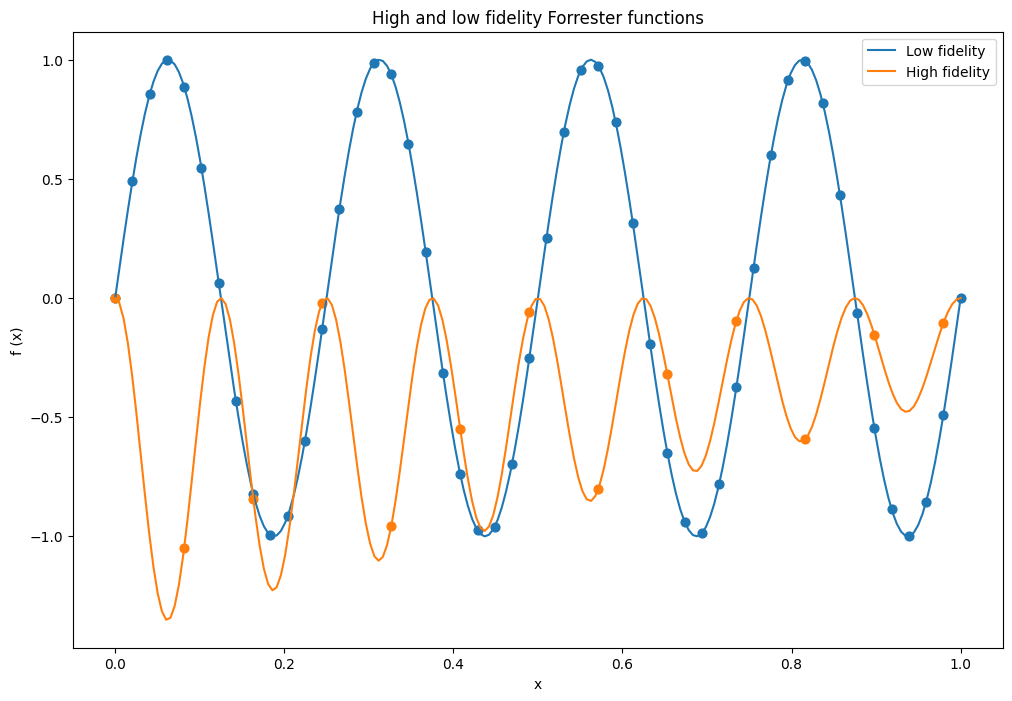

In [7]:
## Plot the original functions

plt.figure(figsize=(12, 8))
plt.plot(x_plot, y_plot_l, "C0")
plt.plot(x_plot, y_plot_h, "C1")
plt.scatter(x_train_l, y_train_l, color="C0", s=40)
plt.scatter(x_train_h, y_train_h, color="C1", s=40)
plt.ylabel("f (x)")
plt.xlabel("x")
plt.legend(["Low fidelity", "High fidelity"])
plt.title("High and low fidelity Forrester functions")


## Multi-fidelity with Non-linear Autoregressive Model

We could define a new kernel class to incorporate two kernels


Here we build two GPs, while passing the 1st GP's output to the second GP.


In [8]:
class ActiveDimension(tfk.FeatureTransformed):
    def __init__(
        self,
        kernel,
        active_dim: List,
        validate_args=False,
        parameters=None,
        name="ActiveDim",
    ) -> None:
        self._transformation_fn = (
            lambda x, feature_ndims, param_expansion_ndims: tf.gather(
                x,
                active_dim,
                axis=-1,
            )
        )

        super(ActiveDimension, self).__init__(
            kernel=kernel,
            transformation_fn=self._transformation_fn,
            validate_args=validate_args,
            parameters=parameters,
            name=name,
        )

        # Keep the kernel so that we can get the batch shape
        self._kernel = kernel

    @property
    def batch_shape(self):
        return self._kernel.batch_shape

    def batch_shape_tensor(self):
        return self._kernel.batch_shape_tensor


In [9]:
n_input_dims = 1
n_output_dim = 1
base_dims_list = list(range(n_input_dims))
out_dims_list = list(range(n_input_dims, n_input_dims + n_output_dim))

In [10]:
def build_gp_lf(amplitude, length_scale, observation_noise_variance):
    """
    Low-fidelity:
    Defines the conditional dist. of GP outputs, given kernel parameters.

    X_LF -> GP_LF -> Y_LF

    """

    # Create the covariance kernel, which will be shared between the prior (which we
    # use for maximum likelihood training) and the posterior (which we use for
    # posterior predictive sampling)
    kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(
        kernel=kernel,
        index_points=x_train_l,
        # jibancat: for this example, no need to open the noise
        observation_noise_variance=observation_noise_variance,
    )


def build_gp_nargp(
    scale_amplitude_0,  # HF
    scale_length_scale_0,  # HF
    interaction_amplitude_0,  # HF
    interaction_length_scale_0,  # HF
    bias_amplitude_0,  # HF
    bias_length_scale_0,  # HF
    linear_bias_amplitude_0,  # HF
    linear_slope_amplitude_0,  # HF
    linear_shift_0,
    amplitude_1,  # LF
    length_scale_1,  # LF
    observation_noise_variance_0,
    observation_noise_variance_1,
):
    """
    High-fidelity:
    Defines the conditional dist. of GP outputs, given kernel parameters.

    f_HF = \rho f_LF + \delta

      X_HF -> GP_LF -> f_LF
      X_HF -> GP_HF -> delta_HF
                  -> f_LF * rho + delta_HF
    """
    # HF kernel
    scale_kernel = ActiveDimension(
        tfk.ExponentiatedQuadratic(scale_amplitude_0, scale_length_scale_0),
        active_dim=out_dims_list,
    )
    scale_kernel += ActiveDimension(
        tfk.Linear(
            bias_amplitude=linear_bias_amplitude_0,
            slope_amplitude=linear_slope_amplitude_0,
            shift=linear_shift_0,
        ),
        active_dim=out_dims_list,
    )
    interaction_kernel = ActiveDimension(
        tfk.ExponentiatedQuadratic(interaction_amplitude_0, interaction_length_scale_0),
        active_dim=base_dims_list,
    )
    bias_kernel = ActiveDimension(
        tfk.ExponentiatedQuadratic(bias_amplitude_0, bias_length_scale_0),
        active_dim=base_dims_list,
    )
    # NARGP kernel
    kernel_h = interaction_kernel * scale_kernel + bias_kernel

    # LF kernel
    kernel_l1 = tfk.ExponentiatedQuadratic(amplitude_1, length_scale_1)
    ## Mean predictions from the LF GP
    gprm_l1 = tfd.GaussianProcessRegressionModel(
        kernel=kernel_l1,
        index_points=x_train_h,
        observation_index_points=x_train_l,
        observations=y_train_l[:, 0],
        observation_noise_variance=observation_noise_variance_1,
        predictive_noise_variance=0.0,
    )
    m1 = gprm_l1.mean()

    ## Index points for H include [X, mean from L1]
    index_points_h = tf.concat([x_train_h, m1[:, None]], axis=1)

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(
        kernel=kernel_h,
        index_points=index_points_h,
        # jibancat: for this example, no need to open the noise
        observation_noise_variance=observation_noise_variance_0,
    )


gp_joint_model_lf = tfd.JointDistributionNamed(
    {
        "amplitude": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "length_scale": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "observation_noise_variance": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "observations": build_gp_lf,
    }
)

gp_joint_model_hf = tfd.JointDistributionNamed(
    {
        "scale_amplitude_0": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "scale_length_scale_0": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "interaction_amplitude_0": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "interaction_length_scale_0": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "bias_amplitude_0": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "bias_length_scale_0": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "linear_bias_amplitude_0": tfd.LogNormal(
            loc=0.0, scale=np.float64(1.0)
        ),  # linear
        "linear_slope_amplitude_0": tfd.LogNormal(
            loc=0.0, scale=np.float64(1.0)
        ),  # linear
        "linear_shift_0": tfd.Normal(loc=0.0, scale=np.float64(1.0)),  # linear
        "amplitude_1": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "length_scale_1": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "observation_noise_variance_0": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "observation_noise_variance_1": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "observations": build_gp_nargp,
    }
)

In [11]:
# Test the batch shape
gp_joint_model_lf.batch_shape, gp_joint_model_hf.batch_shape

Instructions for updating:
`jitter` is deprecated; please use `marginal_fn` directly.
Instructions for updating:
`always_yield_multivariate_normal` is deprecated. This arg is now ignoredand will be removed after 2023-07-01. A `GaussianProcess` evaluated at asingle index point now always has event shape `[1]` (the previous behaviorfor `always_yield_multivariate_normal=True`). To reproduce the previous behavior of `always_yield_multivariate_normal=False`, squeeze the rightmost singleton dimension from the output of `mean`, `sample`, etc.
Instructions for updating:
`always_yield_multivariate_normal` is deprecated. This arg is now ignoredand will be removed after 2023-07-01. A `GaussianProcessRegressionModel`evaluated at a single index point now always has event shape `[1]` (theprevious behavior for `always_yield_multivariate_normal=True`). Toreproduce the previous behavior of`always_yield_multivariate_normal=False`, squeeze the rightmost singletondimension from the output of `mean`, `samp

({'observation_noise_variance': TensorShape([]),
  'length_scale': TensorShape([]),
  'amplitude': TensorShape([]),
  'observations': TensorShape([])},
 {'scale_length_scale_0': TensorShape([]),
  'scale_amplitude_0': TensorShape([]),
  'observation_noise_variance_1': TensorShape([]),
  'observation_noise_variance_0': TensorShape([]),
  'linear_slope_amplitude_0': TensorShape([]),
  'linear_shift_0': TensorShape([]),
  'linear_bias_amplitude_0': TensorShape([]),
  'length_scale_1': TensorShape([]),
  'interaction_length_scale_0': TensorShape([]),
  'interaction_amplitude_0': TensorShape([]),
  'bias_length_scale_0': TensorShape([]),
  'bias_amplitude_0': TensorShape([]),
  'amplitude_1': TensorShape([]),
  'observations': TensorShape([])})

Set the learnable parameters and train based on the maximum marginal likelihoods of two GPs.


In [12]:
# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.
# jibancat: the scale parameter no needs to be positive,
# but I guess it's okay to constrain it to be positive so the delta would
# compensate the sign difference.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

scale_amplitude_var_0 = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="scale_amplitude_0",
    dtype=np.float64,
)
scale_length_scale_var_0 = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="scale_length_scale_0",
    dtype=np.float64,
)
interaction_amplitude_var_0 = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="interaction_amplitude_0",
    dtype=np.float64,
)
interaction_length_scale_var_0 = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="interaction_length_scale_0",
    dtype=np.float64,
)
bias_amplitude_var_0 = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="bias_amplitude_0",
    dtype=np.float64,
)
bias_length_scale_var_0 = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="bias_length_scale_0",
    dtype=np.float64,
)

# Linear kernel
linear_bias_amplitude_var_0 = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="linear_bias_amplitude_0",
    dtype=np.float64,
)
linear_slope_amplitude_var_0 = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="linear_slope_amplitude_0",
    dtype=np.float64,
)
linear_shift_var_0 = tf.Variable(
    initial_value=0.0,
    name="linear_shift_0",
    dtype=np.float64,
)

# Noise
observation_noise_variance_var_0 = tfp.util.TransformedVariable(
    initial_value=1e-4,
    bijector=constrain_positive,
    name="observation_noise_variance_var_0",
    dtype=np.float64,
)

# L1 parameters
amplitude_var_1 = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=constrain_positive, name="amplitude_1", dtype=np.float64
)

length_scale_var_1 = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="length_scale_1",
    dtype=np.float64,
)

observation_noise_variance_var_1 = tfp.util.TransformedVariable(
    initial_value=1e-4,
    bijector=constrain_positive,
    name="observation_noise_variance_var_1",
    dtype=np.float64,
)

trainable_variables = [
    v.trainable_variables[0]
    for v in [
        scale_amplitude_var_0,
        scale_length_scale_var_0,
        interaction_amplitude_var_0,
        interaction_length_scale_var_0,
        bias_amplitude_var_0,
        bias_length_scale_var_0,
        observation_noise_variance_var_0,
        linear_bias_amplitude_var_0,
        linear_slope_amplitude_var_0,
        amplitude_var_1,
        length_scale_var_1,
        observation_noise_variance_var_1,
    ]
]
trainable_variables.append(linear_shift_var_0)


Let's test if we can compute the log prob


In [13]:
x_l = gp_joint_model_lf.sample()
lp_l = gp_joint_model_lf.log_prob(x_l)

print("sampled {}".format(x_l))
print("log_prob of sample: {}".format(lp_l))

sampled {'observation_noise_variance': <tf.Tensor: shape=(), dtype=float64, numpy=0.43338893821709545>, 'length_scale': <tf.Tensor: shape=(), dtype=float64, numpy=2.9845164940687168>, 'amplitude': <tf.Tensor: shape=(), dtype=float64, numpy=0.14379054479897116>, 'observations': <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([ 0.90682419, -0.05321247, -0.08557137,  0.56963938,  0.44047058,
        0.42124055, -0.76615837,  1.13534002, -0.29102932,  0.07947736,
        1.27799474, -0.56344923,  0.27516756, -0.18211929, -0.06429809,
       -0.33770236,  0.42421107,  0.5447865 ,  0.24647901,  0.42740754,
        0.26006165, -0.98405473, -0.49506959,  0.74814046,  0.60243985,
        0.44255717,  0.4963426 , -0.26347076, -0.63711848,  0.6474588 ,
       -0.91320912,  0.45494827, -0.88886373, -0.64675078, -1.03434602,
       -0.33340092, -0.75360381, -0.68617405,  0.86974755,  0.54013264,
       -1.13784453,  0.23351031, -0.30814296,  1.31384442, -0.0884488 ,
        0.01176954, -1.0665

In [14]:
x_h = gp_joint_model_hf.sample()
lp_h = gp_joint_model_hf.log_prob(x_h)

print("sampled {}".format(x_h))
print("log_prob of sample: {}".format(lp_h))


sampled {'scale_length_scale_0': <tf.Tensor: shape=(), dtype=float64, numpy=3.6802383470030353>, 'scale_amplitude_0': <tf.Tensor: shape=(), dtype=float64, numpy=1.9230770048128178>, 'observation_noise_variance_1': <tf.Tensor: shape=(), dtype=float64, numpy=2.402025006656949>, 'observation_noise_variance_0': <tf.Tensor: shape=(), dtype=float64, numpy=1.7548405715935222>, 'linear_slope_amplitude_0': <tf.Tensor: shape=(), dtype=float64, numpy=0.8321259477230347>, 'linear_shift_0': <tf.Tensor: shape=(), dtype=float64, numpy=0.6722631081223573>, 'linear_bias_amplitude_0': <tf.Tensor: shape=(), dtype=float64, numpy=1.547432083038481>, 'length_scale_1': <tf.Tensor: shape=(), dtype=float64, numpy=9.295923165869002>, 'interaction_length_scale_0': <tf.Tensor: shape=(), dtype=float64, numpy=2.363938944392442>, 'interaction_amplitude_0': <tf.Tensor: shape=(), dtype=float64, numpy=4.60802508828315>, 'bias_length_scale_0': <tf.Tensor: shape=(), dtype=float64, numpy=1.2105375726177368>, 'bias_amplitu

To condition the model on our observed data, we'll define a `target_log_prob` function, which takes the (still to be inferred) kernel hyperparameters.

We will combine the log likelihoods from both GP_LF and GP_HF to be one joint likelihood.


In [15]:
def target_log_prob(
    scale_amplitude_0,  # HF
    scale_length_scale_0,  # HF
    interaction_amplitude_0,  # HF
    interaction_length_scale_0,  # HF
    bias_amplitude_0,  # HF
    bias_length_scale_0,  # HF
    observation_noise_variance_0,
    linear_bias_amplitude_0,
    linear_slope_amplitude_0,
    linear_shift_0,
    amplitude_1,
    length_scale_1,
    observation_noise_variance_1,
):
    """
    Loglike(LF) + Loglike(HF)
    """

    log_prob_lf = gp_joint_model_lf.log_prob(
        {
            "amplitude": amplitude_1,
            "length_scale": length_scale_1,
            "observation_noise_variance": observation_noise_variance_1,
            "observations": y_train_l[:, 0],
        }
    )

    log_prob_hf = gp_joint_model_hf.log_prob(
        {
            "scale_amplitude_0": scale_amplitude_0,
            "scale_length_scale_0": scale_length_scale_0,
            "interaction_amplitude_0": interaction_amplitude_0,
            "interaction_length_scale_0": interaction_length_scale_0,
            "bias_amplitude_0": bias_amplitude_0,
            "bias_length_scale_0": bias_length_scale_0,
            "linear_bias_amplitude_0": linear_bias_amplitude_0,
            "linear_slope_amplitude_0": linear_slope_amplitude_0,
            "linear_shift_0": linear_shift_0,
            "amplitude_1": amplitude_1,
            "length_scale_1": length_scale_1,
            "observation_noise_variance_0": observation_noise_variance_0,
            "observation_noise_variance_1": observation_noise_variance_1,
            "observations": y_train_h[:, 0],
        }
    )

    return tf.reduce_sum([log_prob_hf, log_prob_lf])


In [16]:
# Now we optimize the model parameters.
num_iters = 10000
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)


# Fixed noise
@tf.function(autograph=False, jit_compile=False)
def train_model_fixed_noise():
    with tf.GradientTape() as tape:
        loss = -target_log_prob(
            scale_amplitude_0=scale_amplitude_var_0,
            scale_length_scale_0=scale_length_scale_var_0,
            interaction_amplitude_0=interaction_amplitude_var_0,
            interaction_length_scale_0=interaction_length_scale_var_0,
            bias_amplitude_0=bias_amplitude_var_0,
            bias_length_scale_0=bias_length_scale_var_0,
            linear_bias_amplitude_0=linear_bias_amplitude_var_0,
            linear_slope_amplitude_0=linear_slope_amplitude_var_0,
            linear_shift_0=linear_shift_var_0,
            amplitude_1=amplitude_var_1,
            length_scale_1=length_scale_var_1,
            observation_noise_variance_0=1e-5,
            observation_noise_variance_1=1e-5,
        )
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    return loss


# Not fix noise
# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
    with tf.GradientTape() as tape:
        loss = -target_log_prob(
            scale_amplitude_0=scale_amplitude_var_0,
            scale_length_scale_0=scale_length_scale_var_0,
            interaction_amplitude_0=interaction_amplitude_var_0,
            interaction_length_scale_0=interaction_length_scale_var_0,
            bias_amplitude_0=bias_amplitude_var_0,
            bias_length_scale_0=bias_length_scale_var_0,
            linear_bias_amplitude_0=linear_bias_amplitude_var_0,
            linear_slope_amplitude_0=linear_slope_amplitude_var_0,
            linear_shift_0=linear_shift_var_0,
            amplitude_1=amplitude_var_1,
            length_scale_1=length_scale_var_1,
            observation_noise_variance_0=observation_noise_variance_var_0,
            observation_noise_variance_1=observation_noise_variance_var_1,
        )
    grads = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(grads, trainable_variables))
    return loss


# Fixed noise
for i in range(num_iters):
    _ = train_model_fixed_noise()
    # lls_[i] = loss

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    loss = train_model()
    lls_[i] = loss

print("Trained parameters:")
print("LF amplitude: {}".format(amplitude_var_1._value().numpy()))
print("LF length_scale: {}".format(length_scale_var_1._value().numpy()))
print(
    "LF observation_noise_variance: {}".format(
        observation_noise_variance_var_1._value().numpy()
    )
)
print("HF scale amplitude: {}".format(scale_amplitude_var_0._value().numpy()))
print("HF scale length_scale: {}".format(scale_length_scale_var_0._value().numpy()))
print(
    "HF interaction amplitude: {}".format(interaction_amplitude_var_0._value().numpy())
)
print(
    "HF interaction length_scale: {}".format(
        interaction_length_scale_var_0._value().numpy()
    )
)
print("HF bias amplitude: {}".format(bias_amplitude_var_0._value().numpy()))
print("HF bias length_scale: {}".format(bias_length_scale_var_0._value().numpy()))

print("Linear kernel:")
print("----")
print(
    "HF linear bias amplitude: {}".format(linear_bias_amplitude_var_0._value().numpy())
)
print(
    "HF linear slope amplitude: {}".format(
        linear_slope_amplitude_var_0._value().numpy()
    )
)
print("Noise:")
print("----")
print(
    "HF observation_noise_variance: {}".format(
        observation_noise_variance_var_0._value().numpy()
    )
)
print(
    "LF observation_noise_variance: {}".format(
        observation_noise_variance_var_1._value().numpy()
    )
)


2023-07-26 19:10:57.638979: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Trained parameters:
LF amplitude: 1.8324797505945472
LF length_scale: 0.10399231605728658
LF observation_noise_variance: 0.00014193369140210005
HF scale amplitude: 0.6961651773273005
HF scale length_scale: 0.39634863838534495
HF interaction amplitude: 0.5440992231767606
HF interaction length_scale: 0.9625777790617742
HF bias amplitude: 0.3063789574129101
HF bias length_scale: 0.6862775059440183
Linear kernel:
----
HF linear bias amplitude: 0.3801810203301786
HF linear slope amplitude: 0.27821014043929215
Noise:
----
HF observation_noise_variance: 0.01817476270864664
LF observation_noise_variance: 0.00014193369140210005


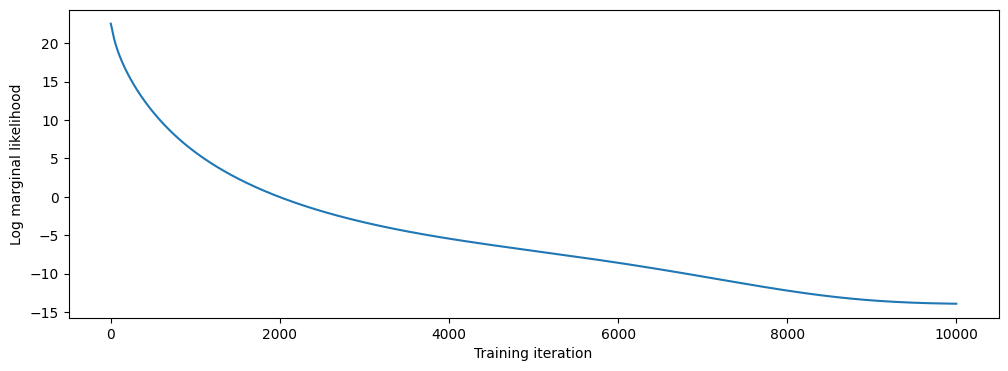

In [17]:
# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")
plt.show()

In [18]:
# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.
predictive_index_points_ = np.linspace(0, 1, 200, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]


# HF kernel
optimized_scale_kernel = ActiveDimension(
    tfk.ExponentiatedQuadratic(scale_amplitude_var_0, scale_length_scale_var_0),
    active_dim=out_dims_list,
)
optimized_scale_kernel += ActiveDimension(
    tfk.Linear(
        bias_amplitude=linear_bias_amplitude_var_0,
        slope_amplitude=linear_slope_amplitude_var_0,
        shift=linear_shift_var_0,
    ),
    active_dim=out_dims_list,
)

optimized_interaction_kernel = ActiveDimension(
    tfk.ExponentiatedQuadratic(
        interaction_amplitude_var_0, interaction_length_scale_var_0
    ),
    active_dim=base_dims_list,
)
optimized_bias_kernel = ActiveDimension(
    tfk.ExponentiatedQuadratic(bias_amplitude_var_0, bias_length_scale_var_0),
    active_dim=base_dims_list,
)
# NARGP kernel
optimized_kernel_h = (
    optimized_interaction_kernel * optimized_scale_kernel + optimized_bias_kernel
)


# LF kernel
optimized_kernel_1 = tfk.ExponentiatedQuadratic(amplitude_var_1, length_scale_var_1)

## Passing information from low-fidelity node
# L1 index points
index_optimized_gprm_l1 = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel_1,
    index_points=x_train_h,
    observation_index_points=x_train_l,
    observations=y_train_l[:, 0],
    observation_noise_variance=observation_noise_variance_var_1,
    predictive_noise_variance=np.float64(0.0),
)
# L1 predictive points
optimized_gprm_l1 = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel_1,
    index_points=predictive_index_points_,
    observation_index_points=x_train_l,
    observations=y_train_l[:, 0],
    observation_noise_variance=observation_noise_variance_var_1,
    predictive_noise_variance=np.float64(0.0),
)


## Combine information
index_m1 = index_optimized_gprm_l1.mean()
m1 = optimized_gprm_l1.mean()

index_points_h = tf.concat([x_train_h, index_m1[:, None]], axis=1)
predictive_index_points_h = tf.concat([predictive_index_points_, m1[:, None]], axis=1)

# Create the GP prior distribution, which we will use to train the model
# parameters.
nargp_gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel_h,
    index_points=predictive_index_points_h,
    observation_index_points=index_points_h,  ## observed index point might need to change
    observations=y_train_h[:, 0],
    observation_noise_variance=observation_noise_variance_var_0,
    predictive_noise_variance=np.float64(0.0),
)


# Create op to draw  50 independent samples, each of which is a *joint* draw
# from the posterior at the predictive_index_points_. Since we have 200 input
# locations as defined above, this posterior distribution over corresponding
# function values is a 200-dimensional multivariate Gaussian distribution!
num_samples = 500
samples = nargp_gprm.sample(num_samples)

# # HF only
# h_gprm = tfd.GaussianProcessRegressionModel(
#     kernel=optimized_kernel_h,
#     index_points=predictive_index_points_,
#     observation_index_points=x_train_h,
#     observations=y_train_h[:, 0],
#     observation_noise_variance=observation_noise_variance_var_0,
#     predictive_noise_variance=np.float64(0.0),
# )

# h_samples = h_gprm.sample(num_samples)

# LF only
l1_gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel_1,
    index_points=predictive_index_points_,
    observation_index_points=x_train_l,
    observations=y_train_l[:, 0],
    observation_noise_variance=observation_noise_variance_var_1,
    predictive_noise_variance=np.float64(0.0),
)

l1_samples = l1_gprm.sample(num_samples)

/var/folders/sn/b7hd1bmd569cjwgmtww4mv440000gn/T/ipykernel_72907/2604372218.py:56: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


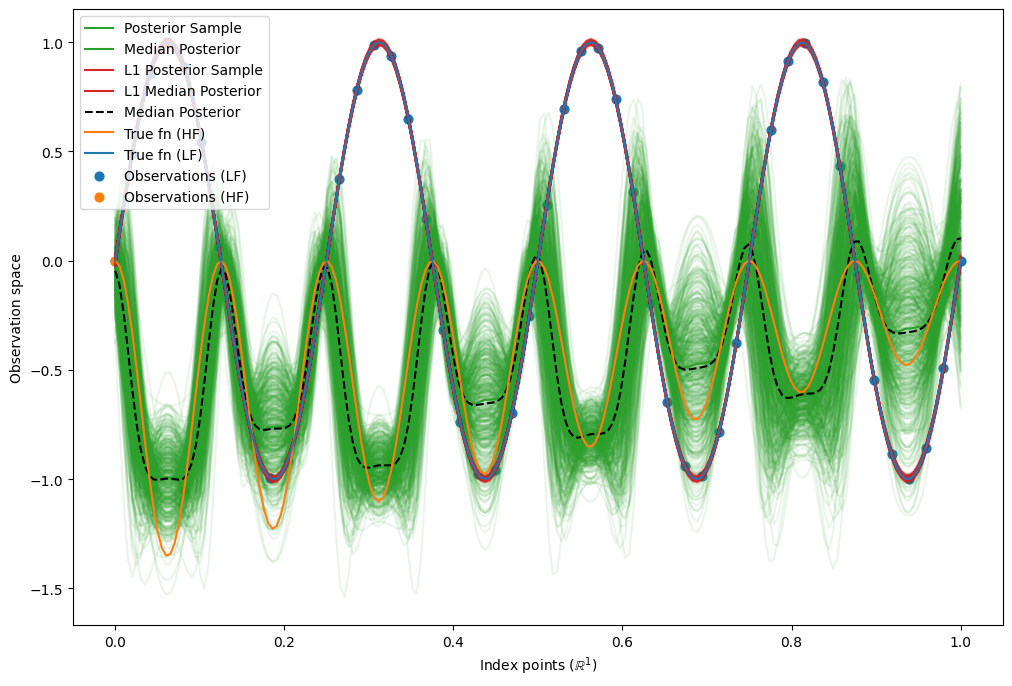

In [20]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 8))

# AR1
for i in range(num_samples):
    plt.plot(
        predictive_index_points_,
        samples[i, :],
        c="C2",
        alpha=0.1,
        label="Posterior Sample" if i == 0 else None,
    )

plt.plot(
    predictive_index_points_,
    np.median(samples, axis=0),
    c="C2",
    label="Median Posterior",
)

# HF
for i in range(num_samples):
    plt.plot(
        predictive_index_points_,
        l1_samples[i, :],
        c="C3",
        alpha=0.05,
        label="L1 Posterior Sample" if i == 0 else None,
    )

plt.plot(
    predictive_index_points_,
    np.median(l1_samples, axis=0),
    c="C3",
    label="L1 Median Posterior",
)

# NARGP mean prediction
plt.plot(
    predictive_index_points_,
    nargp_gprm.mean(),
    c="black",
    ls="--",
    label="Median Posterior",
)


plt.plot(x_plot, y_plot_h, label="True fn (HF)", color="C1")
plt.plot(x_plot, y_plot_l, label="True fn (LF)", color="C0")

plt.scatter(x_train_l, y_train_l, color="C0", s=40, label="Observations (LF)")
plt.scatter(x_train_h, y_train_h, color="C1", s=40, label="Observations (HF)")


leg = plt.legend(loc="upper left")
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()


If you only train on HF data:


In [21]:
def build_gp(amplitude, length_scale, observation_noise_variance):
    """Defines the conditional dist. of GP outputs, given kernel parameters."""

    # Create the covariance kernel, which will be shared between the prior (which we
    # use for maximum likelihood training) and the posterior (which we use for
    # posterior predictive sampling)
    kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

    # Create the GP prior distribution, which we will use to train the model
    # parameters.
    return tfd.GaussianProcess(
        kernel=kernel,
        index_points=x_train_h,
        observation_noise_variance=observation_noise_variance,
    )


gp_joint_model = tfd.JointDistributionNamed(
    {
        "amplitude": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "length_scale": tfd.LogNormal(loc=0.0, scale=np.float64(1.0)),
        "observation_noise_variance": tfd.LogNormal(loc=0.0, scale=np.float64(0.025)),
        "observations": build_gp,
    }
)

# Create the trainable model parameters, which we'll subsequently optimize.
# Note that we constrain them to be strictly positive.

constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.0, bijector=constrain_positive, name="amplitude", dtype=np.float64
)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="length_scale",
    dtype=np.float64,
)

observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.0,
    bijector=constrain_positive,
    name="observation_noise_variance_var",
    dtype=np.float64,
)

trainable_variables_hf_only = [
    v.trainable_variables[0]
    for v in [amplitude_var, length_scale_var, observation_noise_variance_var]
]


def target_log_prob_hf_only(amplitude, length_scale, observation_noise_variance):
    return gp_joint_model.log_prob(
        {
            "amplitude": amplitude,
            "length_scale": length_scale,
            "observation_noise_variance": observation_noise_variance,
            "observations": y_train_h[:, 0],
        }
    )


# Now we optimize the model parameters.
num_iters = 1000
optimizer = tf.optimizers.Adam(learning_rate=0.01)


# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
    with tf.GradientTape() as tape:
        loss = -target_log_prob_hf_only(
            amplitude_var, length_scale_var, observation_noise_variance_var
        )
    grads = tape.gradient(loss, trainable_variables_hf_only)
    optimizer.apply_gradients(zip(grads, trainable_variables_hf_only))
    return loss


# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
    loss = train_model()
    lls_[i] = loss


# Having trained the model, we'd like to sample from the posterior conditioned
# on observations. We'd like the samples to be at points other than the training
# inputs.

# HF only kernel
optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)

h_only_gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=x_train_h,
    observations=y_train_h[:, 0],
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=np.float64(0.0),
)

h_only_samples = h_only_gprm.sample(num_samples)


/var/folders/sn/b7hd1bmd569cjwgmtww4mv440000gn/T/ipykernel_72907/3190600227.py:41: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in leg.legendHandles:


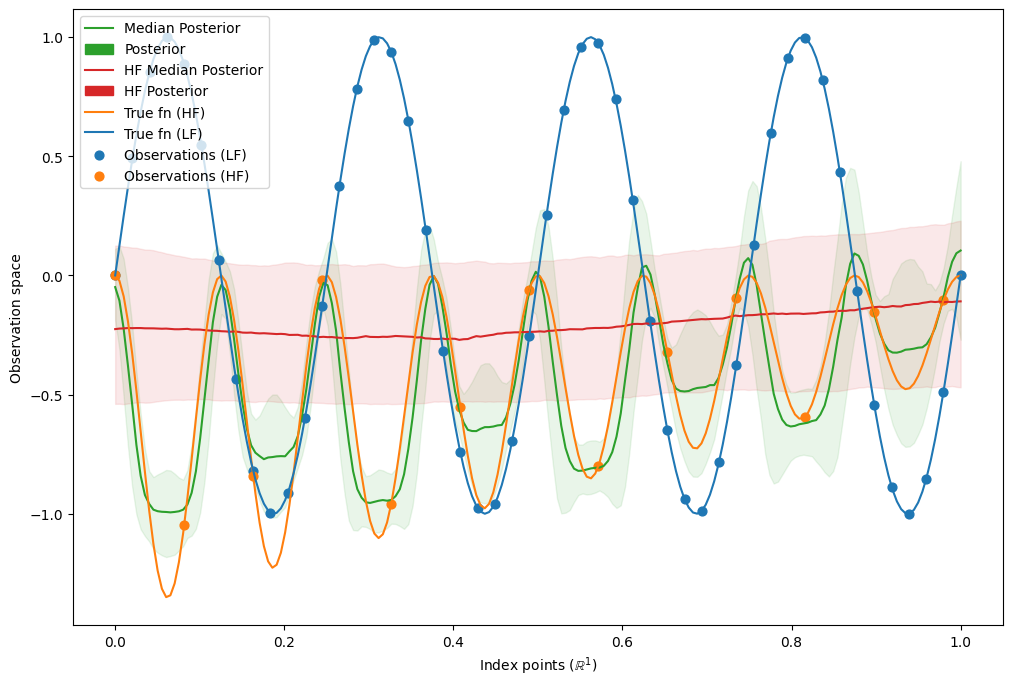

In [22]:
# Plot the true function, observations, and posterior samples.
plt.figure(figsize=(12, 8))

lower, median, upper = np.quantile(samples.numpy(), [0.1, 0.5, 0.9], axis=0)

# AR1
plt.plot(predictive_index_points_, median, c="C2", label="Median Posterior")
plt.fill_between(
    predictive_index_points_[:, 0],
    lower,
    upper,
    color="C2",
    alpha=0.1,
    label="Posterior",
)


lower_hf, median_hf, upper_hf = np.quantile(
    h_only_samples.numpy(), [0.1, 0.5, 0.9], axis=0
)

# HF
plt.plot(predictive_index_points_, median_hf, c="C3", label="HF Median Posterior")
plt.fill_between(
    predictive_index_points_[:, 0],
    lower_hf,
    upper_hf,
    color="C3",
    alpha=0.1,
    label="HF Posterior",
)

plt.plot(x_plot, y_plot_h, label="True fn (HF)", color="C1")
plt.plot(x_plot, y_plot_l, label="True fn (LF)", color="C0")

plt.scatter(x_train_l, y_train_l, color="C0", s=40, label="Observations (LF)")
plt.scatter(x_train_h, y_train_h, color="C1", s=40, label="Observations (HF)")


leg = plt.legend(loc="upper left")
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel(r"Index points ($\mathbb{R}^1$)")
plt.ylabel("Observation space")
plt.show()
